In [1]:
# Import packages & setup dataframes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, ConnectionPatch
from funky import extractor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

In [2]:
# names=['ID', 'M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen', 'Z', 'max_gen', 'Escaped']
df_gc = extractor('gc')
df_nsc = extractor('nsc')
df_ysc = extractor('ysc')

# RFClassifier

## First Generation

The first thing we want is to check if it is possible to predict from the initial conditions - i.e. from the data of the first generation of each BBH - the maximum generation reached by each BBH.

In [3]:
def classes(gen):
    if gen > 3: return 3
    return gen - 1

In [4]:
first_gen = df_nsc[df_nsc['gen'] == 2]
dumped_features = ['ID', 'gen', 'max_gen']
x_train, x_test, y_train, y_test = train_test_split((train_feats := first_gen.drop(columns=dumped_features)), first_gen['max_gen'].transform(classes), test_size=0.2)


forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
print(classification_report(y_test, forest.predict(x_test), target_names=['Max gen 2', 'Max gen 3', 'Max gen above 3']))
print(f'train size: {len(first_gen)}\ntest size: {len(y_test)}')
print(confusion_matrix(y_test, forest.predict(x_test), normalize='true'))

                 precision    recall  f1-score   support

      Max gen 2       1.00      1.00      1.00    479659
      Max gen 3       0.92      0.63      0.75     31908
Max gen above 3       0.19      0.65      0.30      4379

       accuracy                           0.97    515946
      macro avg       0.70      0.76      0.68    515946
   weighted avg       0.99      0.97      0.98    515946

train size: 2579726
test size: 515946
[[1.00 0.00 0.00]
 [0.00 0.63 0.37]
 [0.00 0.35 0.65]]


In [8]:
gc_first_gen = df_gc[df_gc['gen'] == 2]
gc_test = gc_first_gen.drop(columns=dumped_features)
confusion_matrix(gc_first_gen['max_gen'].transform(classes), forest.predict(gc_test), normalize='true')

array([[1.00, 0.00, 0.00],
       [0.00, 0.76, 0.24],
       [0.00, 0.66, 0.34]])

In [9]:
ysc_first_gen = df_ysc[df_ysc['gen'] == 2]
ysc_test = ysc_first_gen.drop(columns=dumped_features)
confusion_matrix(ysc_first_gen['max_gen'].transform(classes), forest.predict(ysc_test), normalize='true')

array([[0.87, 0.13],
       [0.00, 1.00]])

From the scores we can clearly appreciate that the forest is perfectly able to detect BBH that stop at the second generation, it is somewhat also able to classify those that stop at 3rd generation, but utterly fails in classify those that go beyond.

By the graph below, we infer that the main and practically only interesting feature to do the job is the flag $v_{escape} > v_{kick}$, signaling BBH that are not able to merge due to their escape from the cluster.

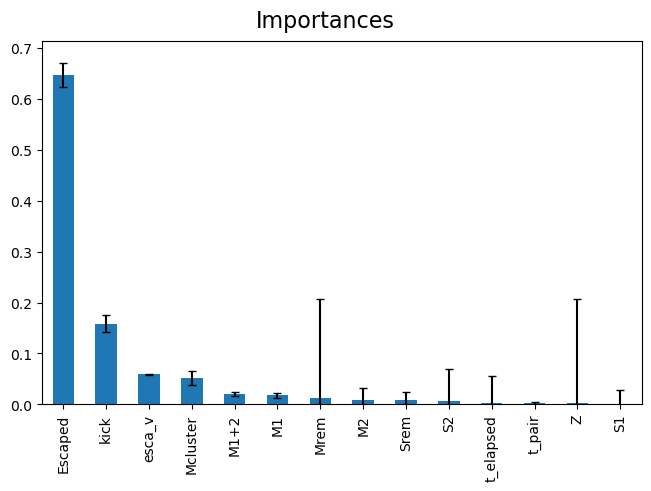

In [28]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

/home/teobaldo/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


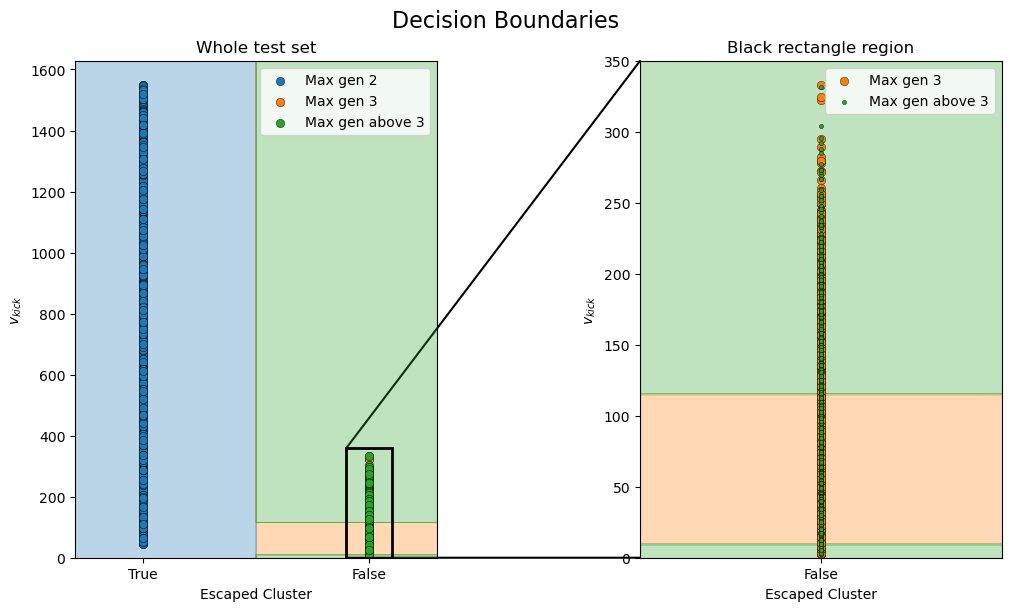

In [29]:
fig, ax = plt.subplots(1,2, figsize=(10,6), layout='constrained')
fig.suptitle('Decision Boundaries', fontsize=16)

forest.fit(x_train[list(importances.index)[:2]], y_train)

feat_1, feat_2 = np.meshgrid(np.linspace(-.5, 1.5, 1000), np.linspace(x_train['kick'].min() - 100, x_train['kick'].max() + 100, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

for target, color, label in zip(y_test.unique(), ['tab:blue', 'tab:orange', 'tab:green'], ['Max gen 2', 'Max gen 3', 'Max gen above 3']):
    idx = y_test[y_test == target].index
    ax[0].scatter(x_test['Escaped'][idx], x_test['kick'][idx], c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
ax[0].set_xlim(-.3, 1.3)
ax[0].set_ylim(0)
ax[0].set_xticks([0,1], [True, False])
ax[0].set_title('Whole test set')
ax[0].add_patch(Rectangle([.9, 0], .2, 360, color='k', lw=2, fill=False, zorder=2.03))
ax[0].add_patch(ConnectionPatch([.9, 360], [0, 1], 'data', 'axes fraction', axesA=ax[0], axesB=ax[1], lw=1.5))
ax[0].add_patch(ConnectionPatch([.9, 0], [0, 0], 'data', 'axes fraction', axesA=ax[0], axesB=ax[1], lw=1.5))

for target, color, label, marker in zip(y_test.unique()[1:], ['tab:orange', 'tab:green'], ['Max gen 3', 'Max gen above 3'], ['o', '.']):
    idx = y_test[y_test == target].index
    ax[1].scatter(x_test['Escaped'][idx], x_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
ax[1].set_xlim(0.9, 1.1)
ax[1].set_ylim(0,350)
ax[1].set_xticks([1], [False])
ax[1].set_title('Black rectangle region')


for Ax in ax:
    Ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=ListedColormap(['tab:blue', 'tab:orange', 'tab:green']))
    Ax.set_xlabel('Escaped Cluster')
    Ax.set_ylabel('$v_{kick}$')
    Ax.legend()
plt.show()

## What if we drop first gens?

In [7]:
first_gen = df_nsc[df_nsc['gen'] == 2].where(df_nsc['max_gen'] != 2).dropna()
dumped_features = ['ID', 'gen', 'max_gen']
x_train, x_test, y_train, y_test = train_test_split((train_feats := first_gen.drop(columns=dumped_features)), first_gen['max_gen'].transform(classes), test_size=0.2)


forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
print(classification_report(y_test, forest.predict(x_test), target_names=['Max gen 3', 'Max gen above 3']))
print(f'train size: {len(first_gen)}\ntest size: {len(y_test)}')

                 precision    recall  f1-score   support

      Max gen 3       0.93      0.63      0.75     31965
Max gen above 3       0.19      0.67      0.30      4250

       accuracy                           0.64     36215
      macro avg       0.56      0.65      0.53     36215
   weighted avg       0.85      0.64      0.70     36215

train size: 181075
test size: 36215


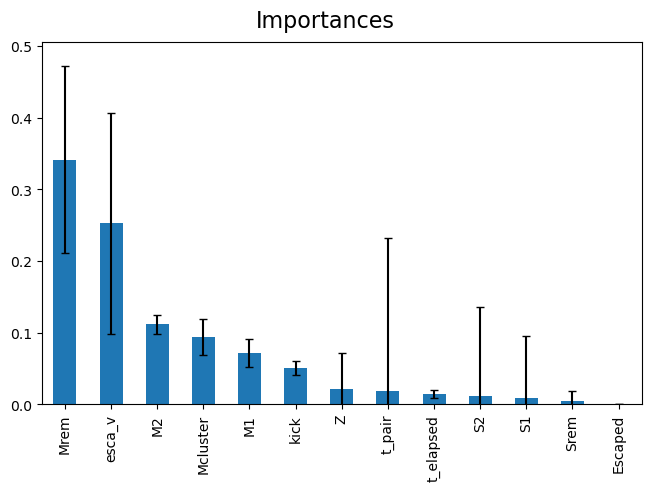

In [8]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

/home/teobaldo/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


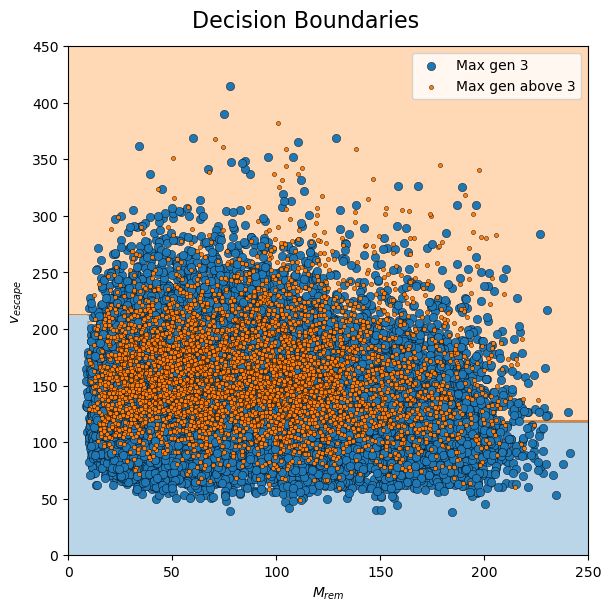

In [9]:
fig, ax = plt.subplots(figsize=(6,6), layout='constrained')
fig.suptitle('Decision Boundaries', fontsize=16)

forest.fit(x_train[list(importances.index)[:2]], y_train)

feat_1, feat_2 = np.meshgrid(np.linspace(x_train['Mrem'].min() - 1000, x_train['Mrem'].max() + 1000, 1000), np.linspace(0, 500, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=ListedColormap(['tab:blue', 'tab:orange']))
for target, color, label, marker in zip(y_test.unique(), ['tab:blue', 'tab:orange'], ['Max gen 3', 'Max gen above 3'], ['o', '.']):
    idx = y_test[y_test == target].index
    ax.scatter(x_test['Mrem'][idx], x_test['esca_v'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
#ax.set_ylim(0,350)


ax.set_ylabel('$v_{escape}$')
ax.set_xlabel('$M_{rem}$')
ax.set_xlim(0, 250)
ax.set_ylim(0, 450)
ax.legend()
plt.show()

## Targeted generation

Acknowledged these results we try to appl

In [10]:
# separate test set, create label set
gen_prec = df_nsc[df_nsc['gen'] == 4]
dumped_features = ['ID', 'gen', 'max_gen']

x_train, x_test, y_train, y_test = train_test_split((train_feats := gen_prec.drop(columns=dumped_features)), gen_prec['max_gen'] > 4, test_size=0.2)


forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
#print(classification_report(fate_test, forest.predict(nsc_test)))
print(f'train size: {len(gen_prec)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 21486
test size: 4298
0.9988366682177757


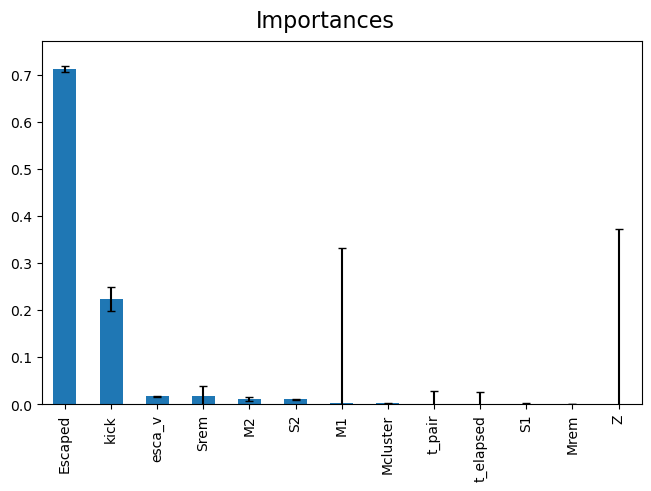

In [11]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

/home/teobaldo/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


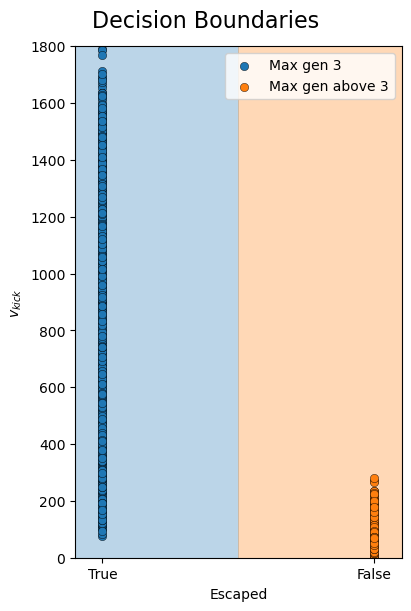

In [12]:
fig, ax = plt.subplots(figsize=(4,6), layout='constrained')
fig.suptitle('Decision Boundaries', fontsize=16)

forest.fit(x_train[list(importances.index)[:2]], y_train)

feat_1, feat_2 = np.meshgrid(np.linspace(-.5, 1.5, 1000), np.linspace(x_train['kick'].min() - 100, x_train['kick'].max() + 100, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=ListedColormap(['tab:blue', 'tab:orange']))
for target, color, label in zip(y_test.unique(), ['tab:blue', 'tab:orange'], ['Max gen 3', 'Max gen above 3']):
    idx = y_test[y_test == target].index
    ax.scatter(x_test['Escaped'][idx], x_test['kick'][idx], c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
#ax.set_ylim(0,350)


ax.set_ylabel('$v_{kick}$')
ax.set_xlabel('Escaped')
ax.set_xlim(-.1, 1.1)
ax.set_ylim(0, 1800)
ax.set_xticks([0,1], [True, False])
ax.legend()
plt.show()

# RFRegressor

## Spin of the Remnant

In [13]:
dumped_features = ['ID', 'Srem', 'max_gen', 'Escaped']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['Srem'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=15, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 2230650
test size: 557663
0.9781940630649641


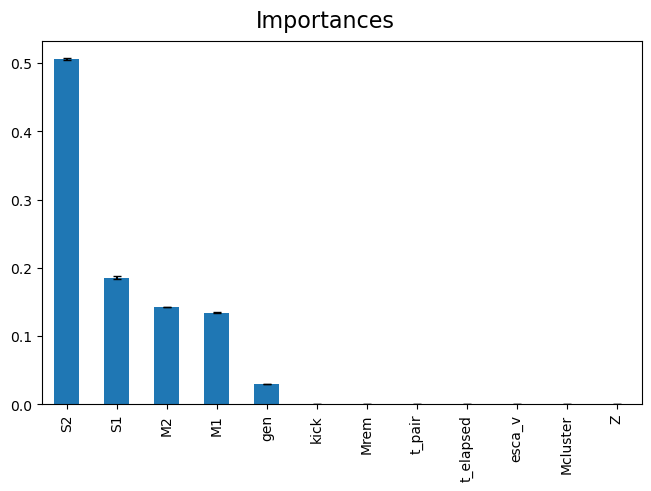

In [14]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

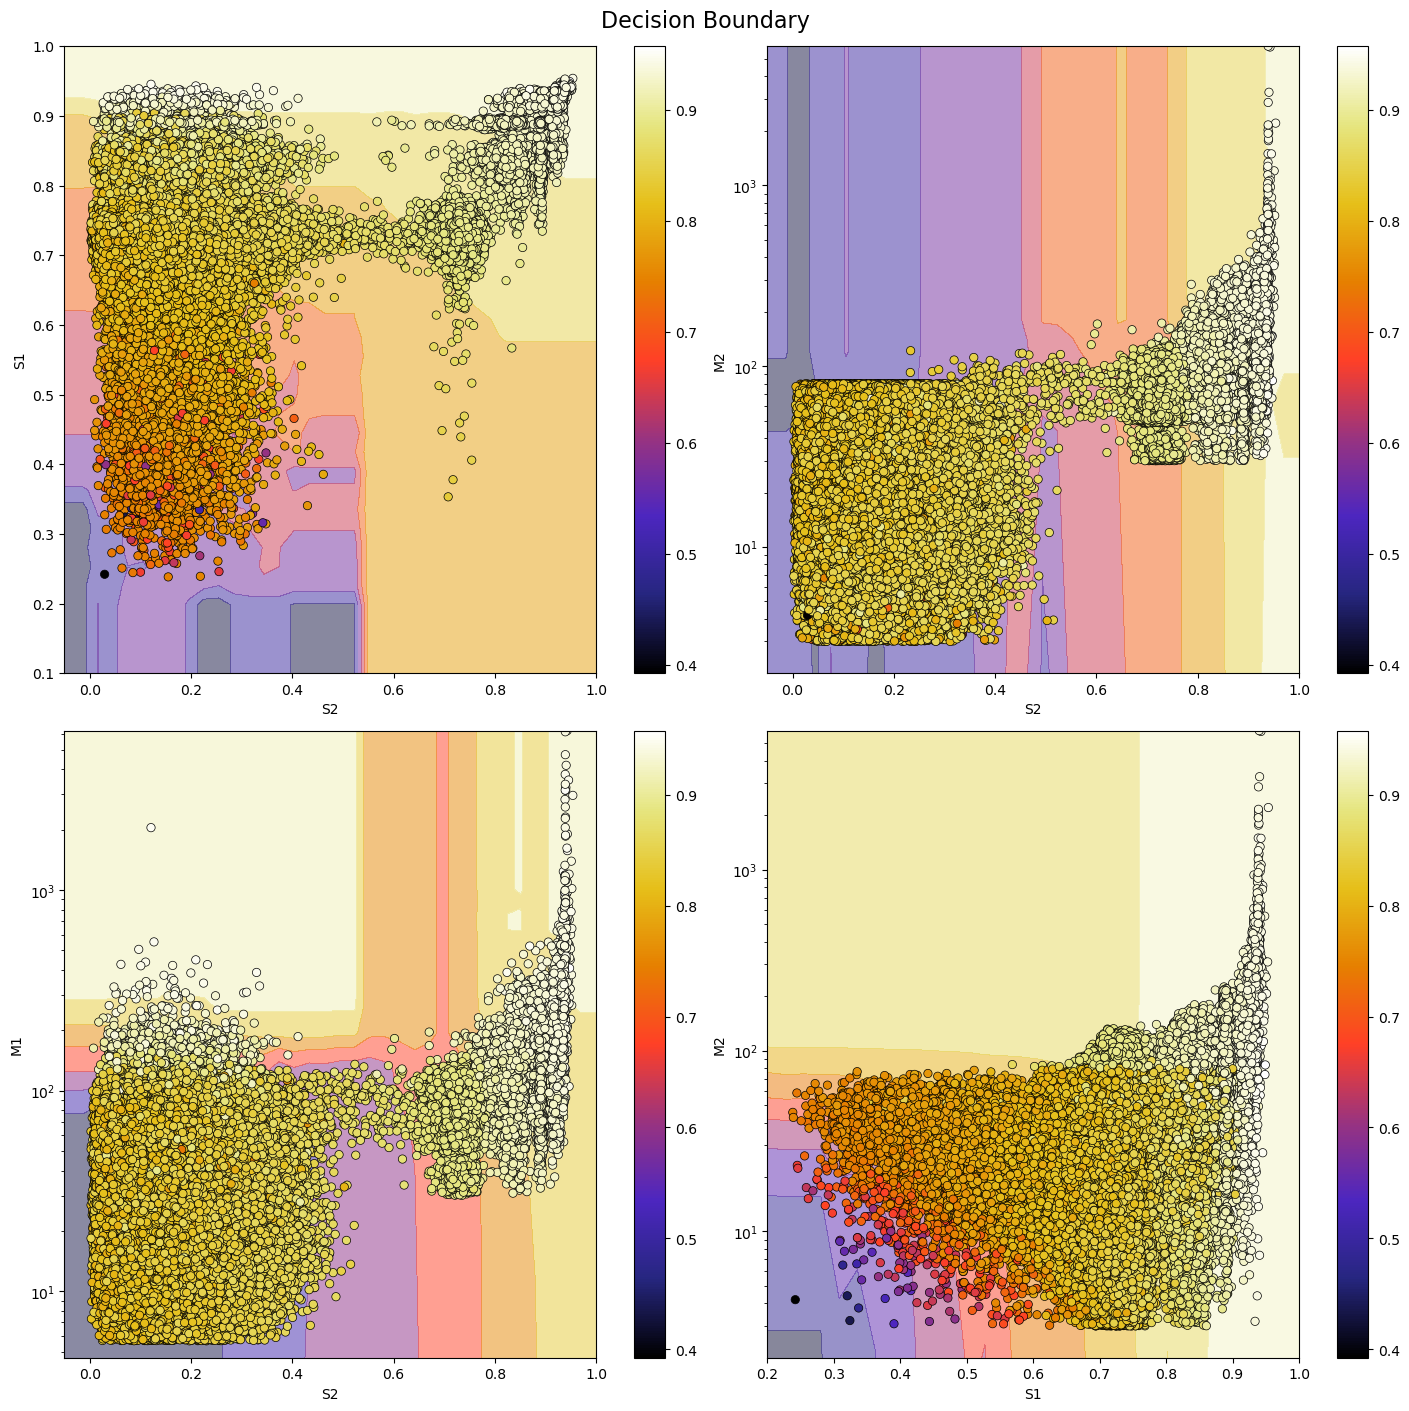

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(14,14), layout='constrained')
fig.suptitle('Decision Boundary', fontsize=16)


forest.fit(x_train[( important_features := list(importances.index[:2]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[0,0])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[0,0].set_xlim(-.05, 1)
ax[0,0].set_ylim(0.1, 1)
fig.colorbar(im)


forest.fit(x_train[( important_features := list(importances.index[[0,2]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[0,1])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(-.05, 1)
fig.colorbar(im)


forest.fit(x_train[( important_features := list(importances.index[[0,3]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[1,0])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim(-.05, 1)
fig.colorbar(im)


forest.fit(x_train[( important_features := list(importances.index[[1,2]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[1,1])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[1,1].set_yscale('log')
ax[1,1].set_xlim(.2, 1)
fig.colorbar(im)

plt.show()

## Mass of the Remnant

In [16]:
df_nsc['M1+2'] = df_nsc['M1'] + df_nsc['M2']
dumped_features = ['ID', 'Srem', 'max_gen', 'Escaped', 'esca_v', 'gen', 'Mrem']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['Mrem'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 2230650
test size: 557663
0.998098716700797


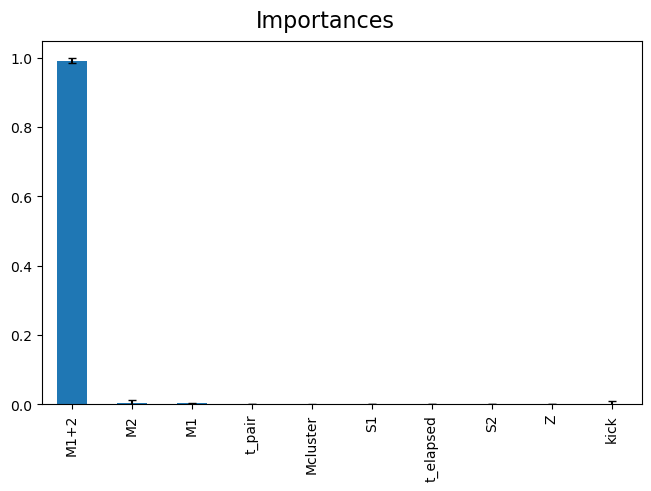

In [17]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

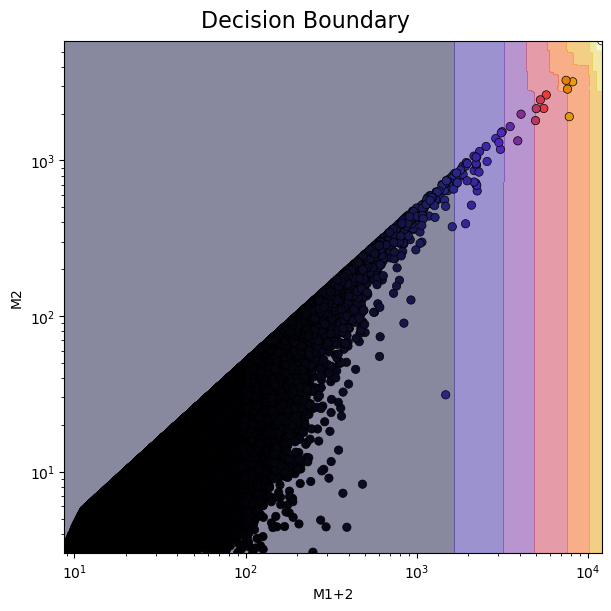

In [18]:
fig, ax = plt.subplots(figsize=(6,6), layout='constrained')
fig.suptitle('Decision Boundary', fontsize=16)

forest.fit(x_train[( important_features := list(importances.index)[:2] )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax)

display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(x_test[important_features[0]].min())
ax.set_ylim(x_test[important_features[1]].min())
plt.show()